In [1]:
%matplotlib inline
import math
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy.stats import ttest_ind, expon, gamma, norm, pearsonr
from itertools import groupby, cycle
from sklearn import metrics

In [2]:
pd.set_option('display.max_colwidth', 50)
pd.set_option('display.latex.repr', True)
# pd.set_option('display.latex.longtable', True)

# CAID
## CAID Framework for explorative data analysis
Critical Assessment of Intrinsic Disorder (CAID) is a continuous experiment where prediction methods for intrinsic disorder (ID) are blind tested on unpublished DisProt data.

In [3]:
ref_path = '/home/marnec/Projects/CAID/data/disorder/new-disprot-all_gene3d.txt'
reference = 'new-disprot-all'
negatives = 'gene3d'
baseline_dir = '/home/marnec/Projects/CAID/baseline'
results_dir = '/home/marnec/Projects/CAID/results'
# labels = './caid_codes.txt'
labels = './caid_names.txt'

In [4]:
def get_ref_dict(ref_file):
    """Load reference in dict. Disprot are used as keys"""
    ref = {}
    with open(ref_file) as f:
        faiter = (x[1] for x in groupby(f, lambda line: line[0] == ">"))
        for header in faiter:
            header = next(header)
            if header[0] != '#':
                acc, *desc = header[1:].strip().split()
                seq, states = map(str.strip, next(faiter))
                nastates = np.fromiter(map({'0': 0, '1': 1, '-': np.nan}.get, states), dtype=float)
                ref[acc] = {'seq': seq, 'states': nastates}
    return ref

In [5]:
# load reference
refdict = get_ref_dict(ref_path)

In [6]:
def get_pname(ref, negs, btype=None):
    """Build predictor name from parameters"""
    pname = [ref, negs]
    if btype is not None:
        pname.append(btype)
    return '_'.join(pname)


def get_fname(ref, negs, rdir, rtype, btype=None):
    """Get prediction filename from parameter"""
    ext = '.txt' if rtype in ('rocPoints', 'prcPoints') else '.csv'
    fname = [get_pname(ref, negs, btype), rtype]
    return os.path.join(rdir, '_'.join(fname) + ext)

In [7]:
def add_auc(df, ref, negs, rdir, curve, baseline=False):
    """Append AUC from a curve file to a DataFrame"""
    btype='cons' if baseline is True else None
    curvefile = get_fname(ref, negs, rdir, 'rocPoints' if curve is 'roc' else 'prcPoints', btype)
    
    table = []
    if os.path.isfile(curvefile):
        for columns in parse_curve_file(curvefile):
            table.append(columns[:2])
    else:
        table.append([get_pname(ref, negs, btype), np.nan])

    return pd.concat([df, pd.DataFrame(table, columns=['pred', 'AUC-{}'.format(curve)]).set_index(['pred'])], sort=False, axis=1)

In [8]:
def load_scores_tables(ref, negs, base_dir, res_dir, optimized_thr=None):
    if optimized_thr is not None:
        assert optimized_thr in {'ROC', 'Fmax'}
        stype = 'redefScores{}'.format(optimized_thr)
    else:
        stype = 'scores'
    
    # baselines
    bchunk = pd.read_csv(get_fname(ref, negs, base_dir, 'scores', 'chunk'), index_col=[0]).mean().to_frame().transpose()
    bchain = pd.read_csv(get_fname(ref, negs, base_dir, 'scores', 'chain'), index_col=[0]).mean().to_frame().transpose()
    bcons = pd.read_csv(get_fname(ref, negs, base_dir, stype, 'cons'), index_col=[0]).mean().to_frame().transpose().rename(index={0: get_pname(ref, negs, 'cons')})
    bln = [bchunk, bchain, bcons]
    bln_names = ['chunk', 'chain', 'cons']
    if negs != 'gene3d':
        bnaifg = pd.read_csv(get_fname(ref, negs, base_dir, 'scores', 'naive-gene3d'), index_col=[0]).mean().to_frame().transpose()
        bln += [bnaifg]
        bln_names += ['naive-gene3d']
    if negs != 'pdb':
        bnaifp = pd.read_csv(get_fname(ref, negs, base_dir, 'scores', 'naive-pdb'), index_col=[0]).mean().to_frame().transpose()
        bln += [bnaifp]
        bln_names += ['naive-pdb']

    # predictions
    preds = pd.read_csv(get_fname(ref, negs, res_dir, stype), index_col=[0])

    # merge baselines
    base = pd.concat(bln, axis=0, sort=False)
    base.index = bln_names
    return base, preds


def merge_scores_tables(ref, negs, base_dir, res_dir, optimized_thr=None):
    """Merge all baselines and predictors' scores"""
    base, preds = load_scores_tables(ref, negs, base_dir, res_dir, optimized_thr=optimized_thr)
    # merge baselines and predictions
    return pd.concat([preds, base], sort=False).round(3)

In [9]:
def load_target_tables(ref, negs, base_dir, res_dir, optimized_thr=None):
    if optimized_thr is not None:
        assert optimized_thr in {'ROC', 'Fmax'}
        stype = 'perInstanceRedefScores{}'.format(optimized_thr)
    else:
        stype = 'perInstanceScores'
    
    # baselines
    bchunk = pd.read_csv(get_fname(ref, negs, base_dir, 'perInstanceScores', 'chunk'), index_col=[0, 1], header=[0]).groupby(level=1).mean()
    bchunk = bchunk.set_index([['random_chunk']*len(bchunk), bchunk.index])

    bchain = pd.read_csv(get_fname(ref, negs, base_dir, 'perInstanceScores', 'chain'), index_col=[0, 1], header=[0]).groupby(level=1).mean()
    bchain = bchain.set_index([['random_chain']*len(bchain), bchain.index])

    bcons = pd.read_csv(get_fname(ref, negs, base_dir, stype, 'cons'), index_col=[0, 1]).reset_index(level=0, drop=True)
    bcons = bcons.set_index([['cons']*len(bcons), bcons.index])
    bln = [bchunk, bchain, bcons]

    if negs != 'gene3d':
        bnaifg = pd.read_csv(get_fname(ref, negs, base_dir, stype, 'naive-gene3d'), index_col=[0, 1]).reset_index(level=0, drop=True)
        bnaifg = bnaifg.set_index([['naive-gene3d']*len(bnaifg), bnaifg.index])
        bln.append(bnaifg)
        
    if negs != 'pdb':
        bnaifp = pd.read_csv(get_fname(ref, negs, base_dir, stype, 'naive-pdb'), index_col=[0, 1]).reset_index(level=0, drop=True)
        bnaifp = bnaifp.set_index([['naive-pdb']*len(bnaifp), bnaifp.index])
        bln.append(bnaifp)

    # predictions
    preds = pd.read_csv(get_fname(ref, negs, res_dir, stype), index_col=[0, 1], header=[0])
    # merge baselines
    base = pd.concat(bln, axis=0, sort=False)
    
    return base, preds


def merge_targets_tables(ref, negs, base_dir, res_dir, optimized_thr=None):
    """Merge all baselines and predictors' scores"""
    base, preds = load_target_tables(ref, negs, base_dir, res_dir, optimized_thr=optimized_thr)
    # merge all
    return pd.concat([preds, base], sort=False).round(3)

In [10]:
def parse_curve_file(curve_file, parse_code=None):
    """Parse ROC and PRC files"""
    with open(curve_file) as f:
        for line in f:
            code, _, auc, *points = line.split()
            auc = float(auc)
            x, y, thr = zip(*map(lambda s: map(float, s.split(',')), points))
            
            if parse_code is not None and callable(parse_code):
                code = parse_code(code)

            yield code, auc, np.array(x), np.array(y), np.array(thr)

def merge_curves(curve_type):
    curve_type += 'Points'
    parse_naive = lambda c: 'naive-' + c.split('-')[-1]
    preds = list(parse_curve_file(get_fname(reference, negatives, results_dir, curve_type)))
    base_cons = list(parse_curve_file(get_fname(reference, negatives, baseline_dir, curve_type, 'cons'), lambda c: c.split('_')[-1]))
    base_naifg = list(parse_curve_file(get_fname(reference, negatives, baseline_dir, curve_type, 'naive-gene3d')))
    base_naifp = list(parse_curve_file(get_fname(reference, negatives, baseline_dir, curve_type, 'naive-pdb')))
    return preds, base_cons + base_naifg + base_naifp

In [11]:
def load_predstack(fname):
    with open(fname) as f:
        targets = {}
        preds = {}
        for line in f:
            line = line.strip()
            if line[0] == '#':
                target_positions = line[1:].split("#")
                for position in target_positions:
                    target, start, end = position.split(",")
                    targets[target] = (int(start), int(end))
            else:
                method, pred = line.split()
                preds[method] = np.fromiter(map(int, pred), dtype=np.float)

    return targets, preds

def merge_predstacks(fname):
    pass

In [12]:
# build score table (may take a while)
scores = merge_scores_tables(reference, negatives, baseline_dir, results_dir)

In [13]:
# build target-wise score table
target_scores = merge_targets_tables(reference, negatives, baseline_dir, results_dir)

In [14]:
rocs, rocs_base = merge_curves('roc')
prcs, prcs_base = merge_curves('prc')

### Evaluation merics
Metrics calculated on **optimized threshold** obtained from Jouden's J metric

In [15]:
scores.sort_values(by='BAc', ascending=False)

,FN,FP,TN,TP,BAc,FPR,F1s,MCC,Pre,Rec,F1s_n,Pre_n,Rec_n,AUC_PRC,AUC_ROC,npred,nref
naive-pdb,0.00,45103.00,110553.00,54604.00,0.855,0.290,0.708,0.624,0.548,1.000,0.831,1.000,0.710,0.754,0.853,646.0,646.0
D029_SPOT-Disorder2,11513.00,7577.00,124439.00,36238.00,0.851,0.057,0.792,0.722,0.827,0.759,0.929,0.915,0.943,0.863,0.924,610.0,646.0
D028_SPOT-Disorder1,13693.00,10500.00,144865.00,40600.00,0.840,0.068,0.770,0.694,0.795,0.748,0.923,0.914,0.932,0.828,0.923,644.0,646.0
D026_AUCpreD,17070.00,8046.00,144327.00,37485.00,0.817,0.053,0.749,0.675,0.823,0.687,0.920,0.894,0.947,0.836,0.913,644.0,646.0
D002_Predisorder,10526.00,28820.00,121902.00,43971.00,0.808,0.191,0.691,0.568,0.604,0.807,0.861,0.921,0.809,0.795,0.885,642.0,646.0
D025_RawMSA,17363.00,10702.00,144954.00,37241.00,0.807,0.069,0.726,0.641,0.777,0.682,0.912,0.893,0.931,0.794,0.899,646.0,646.0
D008_IsUnstruct,13771.00,23195.00,132461.00,40833.00,0.799,0.149,0.688,0.571,0.638,0.748,0.878,0.906,0.851,0.755,0.874,646.0,646.0
D011_DISOPRED-3.1,19395.00,11288.00,144368.00,35209.00,0.786,0.073,0.697,0.605,0.757,0.645,0.904,0.882,0.927,0.771,0.873,646.0,646.0
D015_VSL2B,10059.00,37996.00,117369.00,44234.00,0.785,0.245,0.648,0.512,0.538,0.815,0.830,0.921,0.755,0.758,0.867,644.0,646.0
D005_IUPred-long,19362.00,12932.00,142652.00,35198.00,0.781,0.083,0.686,0.586,0.731,0.645,0.898,0.880,0.917,0.762,0.865,645.0,646.0


In [16]:
# load base and predictors scores (per-residue)
b, p = load_scores_tables(reference, negatives, baseline_dir, results_dir)
# load base and predictors scores (per-target)
bt, pt = load_target_tables(reference, negatives, baseline_dir, results_dir)

In [17]:
#target_scores

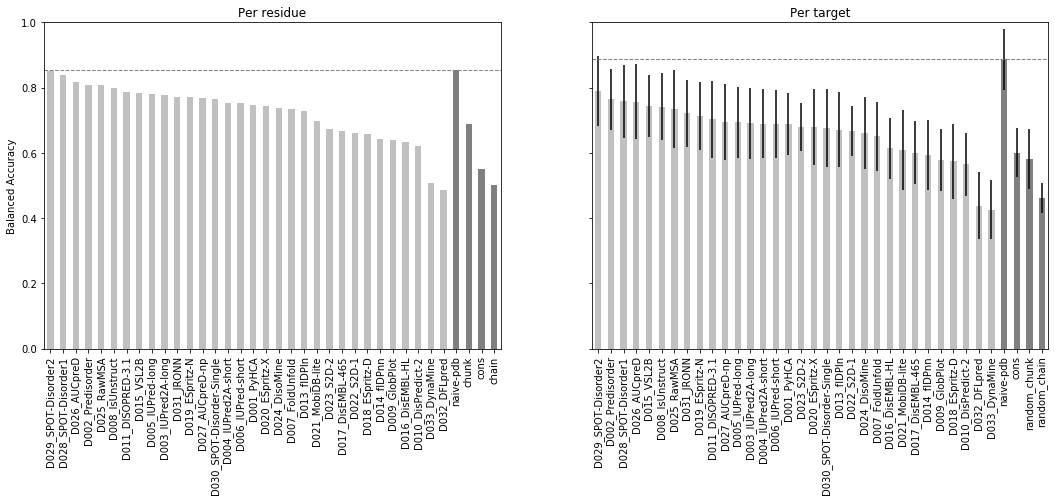

In [18]:
bt_acc_mean, bt_acc_std = bt.xs('bal_acc', level=1).mean(axis=1), bt.xs('bal_acc', level=1).std(axis=1)
pt_acc_mean, pt_acc_std = pt.xs('bal_acc', level=1).mean(axis=1), pt.xs('bal_acc', level=1).std(axis=1)

# init figure
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
# set different colors for prediction and baselines
colors = ['silver'] * len(p) + ['grey'] * len(b)
# draw per-residue bars
p['BAc'].sort_values(ascending=False).append(b['BAc'].sort_values(ascending=False)).plot.bar(color=colors, ax=axes[0])
axes[0].set_ylabel('Balanced Accuracy')
axes[0].set_ylim(0, 1)
axes[0].set_title('Per residue')
# draw horizontal line at maximum baseline
axes[0].axhline(b['BAc'].max(), linestyle='--', color='grey', linewidth=1)
# draw mean per-target bars
acc_mean = pt_acc_mean.sort_values(ascending=False).append(bt_acc_mean.sort_values(ascending=False))
# order std with the same order as mean
acc_std = pt_acc_std.append(bt_acc_std).loc[acc_mean.index]
# plot bars with error
acc_mean.plot.bar(color=colors, ax=axes[1], yerr=acc_std/2)
# draw horizontal line at maximum baseline
axes[1].axhline(bt_acc_mean.max(), linestyle='--', color='grey', linewidth=1)
axes[1].set_ylabel('Balanced Accuracy')
axes[1].set_title('Per target');

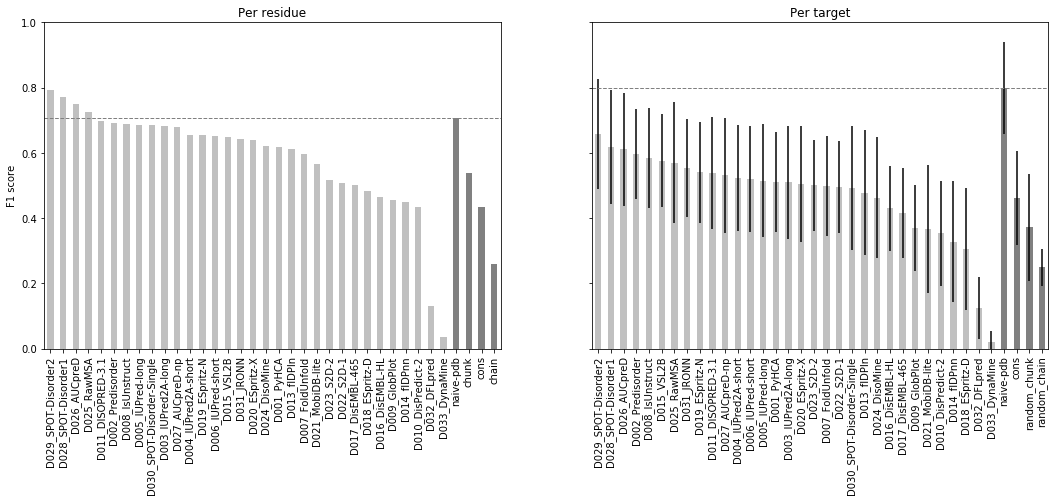

In [19]:
bt_f1s_mean, bt_f1s_std = bt.xs('fscore', level=1).mean(axis=1), bt.xs('fscore', level=1).std(axis=1)
pt_f1s_mean, pt_f1s_std = pt.xs('fscore', level=1).mean(axis=1), pt.xs('fscore', level=1).std(axis=1)
# init figure
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
# set different colors for prediction and baselines
colors = ['silver'] * len(p) + ['grey'] * len(b)
# draw per-residue bars
p['F1s'].sort_values(ascending=False).append(b['F1s'].sort_values(ascending=False)).plot.bar(color=colors, ax=axes[0])
axes[0].set_ylabel('F1 score')
axes[0].set_ylim(0, 1)
axes[0].set_title('Per residue')
# draw horizontal line at maximum baseline
axes[0].axhline(b['F1s'].max(), linestyle='--', color='grey', linewidth=1)
# draw mean per-target bars
f1s_mean = pt_f1s_mean.sort_values(ascending=False).append(bt_f1s_mean.sort_values(ascending=False))
# order std with the same order as mean
f1s_std = pt_f1s_std.append(bt_f1s_std).loc[f1s_mean.index]
# plot bars with error
f1s_mean.plot.bar(color=colors, ax=axes[1], yerr=f1s_std/2)
# draw horizontal line at maximum baseline
axes[1].axhline(bt_f1s_mean.max(), linestyle='--', color='grey', linewidth=1)
axes[1].set_ylabel('F1 score')
axes[1].set_title('Per target');

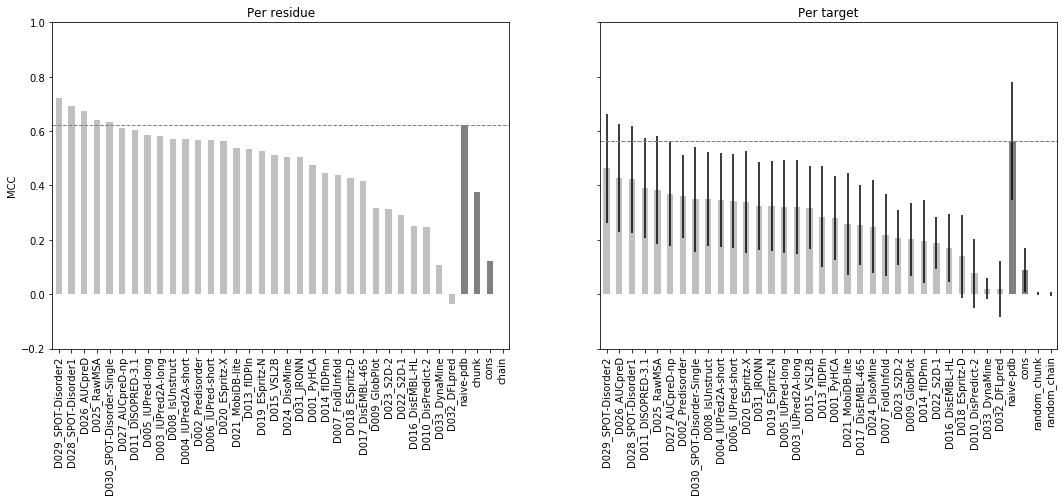

In [20]:
bt_mcc_mean, bt_mcc_std = bt.xs('mcc', level=1).mean(axis=1), bt.xs('mcc', level=1).std(axis=1)
pt_mcc_mean, pt_mcc_std = pt.xs('mcc', level=1).mean(axis=1), pt.xs('mcc', level=1).std(axis=1)
# init figure
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
# set different colors for prediction and baselines
colors = ['silver'] * len(p) + ['grey'] * len(b)
# draw per-residue bars
p['MCC'].sort_values(ascending=False).append(b['MCC'].sort_values(ascending=False)).plot.bar(color=colors, ax=axes[0])
axes[0].set_ylabel('MCC')
axes[0].set_ylim(-.2, 1)
axes[0].set_title('Per residue')
# draw horizontal line at maximum baseline
axes[0].axhline(b['MCC'].max(), linestyle='--', color='grey', linewidth=1)
# draw mean per-target bars
mcc_mean = pt_mcc_mean.sort_values(ascending=False).append(bt_mcc_mean.sort_values(ascending=False))
# order std with the same order as mean
mcc_std = pt_mcc_std.append(bt_mcc_std).loc[mcc_mean.index]
# plot bars with error
mcc_mean.plot.bar(color=colors, ax=axes[1], yerr=mcc_std/2)
# draw horizontal line at maximum baseline
axes[1].axhline(bt_mcc_mean.max(), linestyle='--', color='grey', linewidth=1)
axes[1].axhline(bt_mcc_mean.max(), linestyle='--', color='grey', linewidth=1)
axes[1].set_title('Per target');


## Predictor Accuracy for each target
Heatmap of the predictors accuracy for each target. $x$ and $y$ axes are sorted by the average of the accuracy values in the row and column respectively.

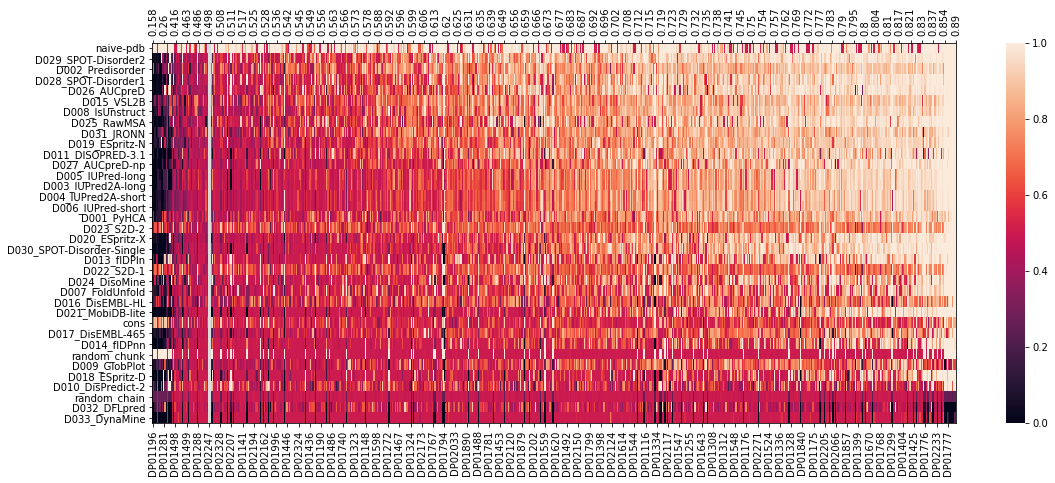

In [21]:
metric = 'bal_acc'
threshold = 0.5

# sort columns by column average
target_heatmap = target_scores.xs(metric, level=1).reindex(target_scores.xs(metric, level=1).mean().sort_values().index, axis=1)
# sort rows by row average
target_heatmap = target_heatmap.loc[target_scores.xs(metric, level=1).mean(axis=1).sort_values(ascending=False).index]

fig, ax = plt.subplots(figsize=(18,7)) 
ax = sns.heatmap(target_heatmap, ax=ax)
ax.axes.get_yaxis().get_label().set_visible(False)
ax.set_facecolor('xkcd:salmon')

def find_nearest(array, value):
    array = np.fromiter(array, dtype=float)
    idx = np.nanargmin(np.abs(array - value))
    return array[idx]

ax2 = ax.twiny()
ax2tick_location = ax.xaxis.get_ticklocs() #Get the tick locations in data coordinates as a numpy array

ax2tick_lbls = [target_heatmap.mean().values[list(target_heatmap.columns).index(l.get_text())] for l in ax.xaxis.get_ticklabels()]

ax2.set_xticks(ax2tick_location)
ax2.set_xticklabels(np.array(ax2tick_lbls).round(3));
thr_x = dict(zip(map(float, ax2tick_lbls), ax2tick_location)).get(find_nearest(map(float, ax2tick_lbls), threshold))
ax.axvline(thr_x, linewidth=3, color='gainsboro')
ax2.tick_params(axis='x', rotation=90)

#DP01196 29466327 23-215 CEM --> 29466327 183-203 CEM

Accuracy score approaches $0.5$ for a random classifier. Accuracy $< 0.5$ indicates anti-correlation between predicted and reference classes.

Targets with an average accuracy score $<0.5$ are:

In [22]:
low_acc_targets = target_heatmap.mean()[target_heatmap.mean() <= 0.5].to_frame()
low_acc_targets.index

Index(['DP01196', 'DP01432', 'DP01456', 'DP01971', 'DP01870', 'DP01248',
       'DP01949', 'DP01366', 'DP01339', 'DP01281', 'DP01177', 'DP02010',
       'DP01128', 'DP01181', 'DP02149', 'DP01512', 'DP01278', 'DP01806',
       'DP01498', 'DP01501', 'DP01883', 'DP02296', 'DP01898', 'DP01584',
       'DP01287', 'DP01307', 'DP01285', 'DP01499', 'DP01195', 'DP01140',
       'DP01600', 'DP01494', 'DP02168', 'DP01505', 'DP01427', 'DP01500',
       'DP01288', 'DP01612', 'DP01355', 'DP01430', 'DP02234', 'DP01503',
       'DP01907', 'DP01139', 'DP02169', 'DP02247'],
      dtype='object')

Commonly, experimental data has a bias for low disorder-content. DisProt targets have high disorder-content. Classifier have been trained/engeneered on low disorder-content. I expect difficult targets to have high disorder content.

Correlation matrix of Balanced accuracy, F1 score, Sequence length and ID content. Average posistion of disorder is codified as color.

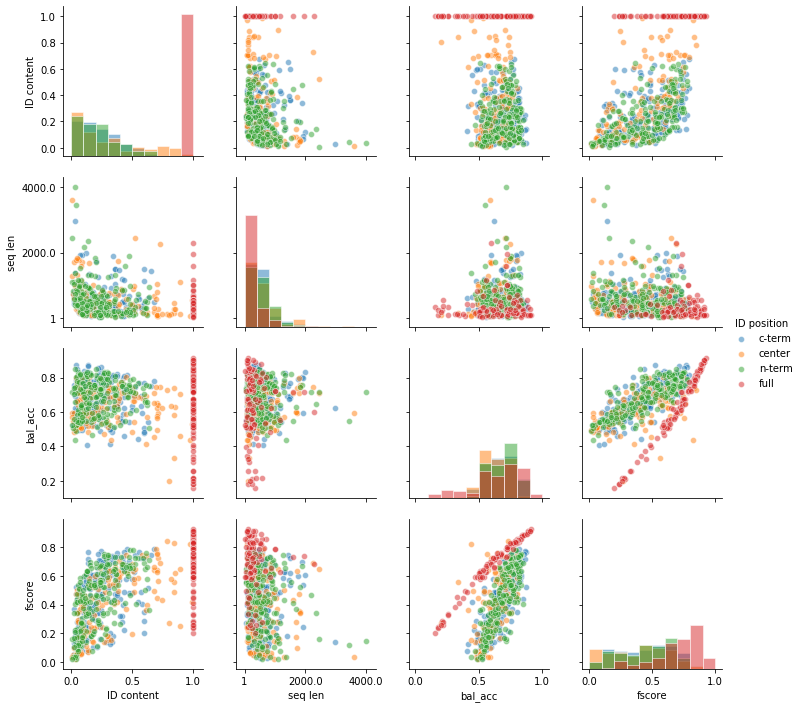

In [23]:
def avg_id_pos(s):
    s = s[~np.isnan(s)]
    p = np.argwhere(s == np.amax(s)).flatten() / s.size
    if np.unique(s).size == 1:
        pos = 'full' if np.mean(s) == 1 else 'none'
    else:
        p = np.mean(p)
        if p < 0.33:
            pos = 'n-term'
        elif 0.33 <= p <= 0.66:
            pos = 'center'
        else:
            pos = 'c-term'
    return pos

# get per-target scores averaged over methods
target_avg_scores = target_scores.mean(level=1).transpose()
# calculate disorder content from loaded reference
id_content = pd.DataFrame([[p, np.nanmean(refdict[p]['states'])] for p in refdict]).set_index([0]).rename(columns={1:'ID content'})
# calculate protein length from loaded reference
p_len = pd.DataFrame([[p, len(refdict[p]['seq'])] for p in refdict]).set_index([0]).rename(columns={1:'seq len'})
# rescale length in range (0, 1) --> I can set range=(0, 1) when drawing 
maxlen = p_len.max().max()
p_len = p_len / maxlen
# calculate average position of disorder in disprot entry
pos = pd.DataFrame([(p, avg_id_pos(refdict[p]['states'])) for p in refdict]).set_index([0]).rename(columns={1:'ID position'})
# concatenate everything 
corr = pd.concat([id_content, target_avg_scores, p_len, pos], axis=1, sort=False)

# draw correlation matrix for selected columns
v = ["ID content", "seq len", "bal_acc", "fscore"]
g = sns.pairplot(corr, vars=v, hue="ID position", diag_kind="hist",
                 plot_kws={'alpha': 0.5}, # set transparency of dots
                 diag_kws={'alpha': 0.5, # set transparency of hist bars
                           'edgecolor': 'w', # set edge color of hist bars
                           'bins': 10, 'range': (0, 1), # make all bins boundaries equal
                           'density': True, }) # rescale y axis in range (0, 1)

# redraw x-ticks of seq len for its actual scale
vi = v.index("seq len")
maxlen = round(maxlen / (10 ** int(math.log10(maxlen)))) * (10 ** int(math.log10(maxlen)))
g.axes[vi, vi].set_xticks([0, 0.5, 1], minor=False)
g.axes[vi, vi].set_xticklabels([1, maxlen / 2, maxlen])
g.axes[vi, vi].set_yticks([0, 0.5, 1], minor=False)
g.axes[vi, vi].set_yticklabels([1, maxlen / 2, maxlen]);

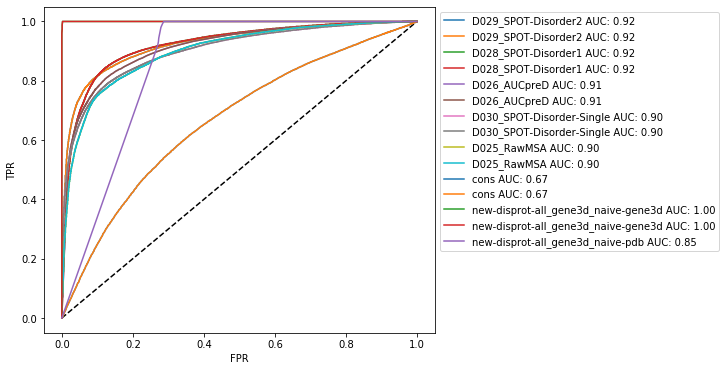

In [24]:
# # initialize a figure and an ax
fig, ax = plt.subplots(figsize=(7, 6))
# # plot diagonal
ax.plot([0, 1], [0, 1], linestyle='--', color='k')

# plot all curves in evaluation file
for curve_data in sorted(rocs, key=lambda d: d[1], reverse=True)[:10] + rocs_base:
    code, auc_roc, x, y, thr = curve_data
    ax.plot(x, y, label='{} AUC: {:.2f}'.format(code, auc_roc))
    
ax.legend(bbox_to_anchor=(1, 1))
ax.set_xlabel('FPR')
ax.set_ylabel('TPR');

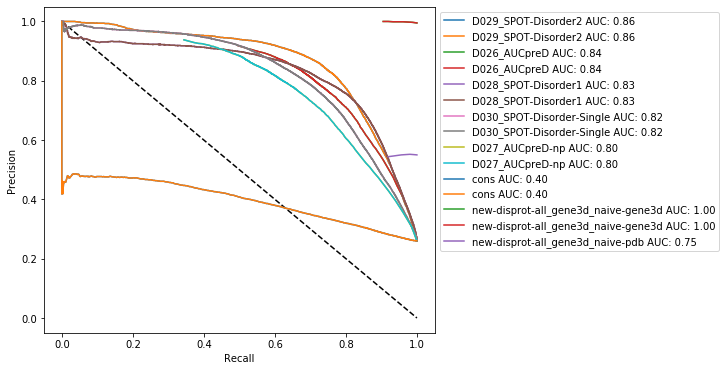

In [25]:
# # initialize a figure and an ax
fig, ax = plt.subplots(figsize=(7, 6))
# # plot diagonal
ax.plot([0, 1], [1, 0], linestyle='--', color='k')

# plot all curves in evaluation file
for curve_data in sorted(prcs , key=lambda d: d[1], reverse=True)[:10] + prcs_base:
    code, auc_score, x, y, thr = curve_data
    ax.plot(x, y, label='{} AUC: {:.2f}'.format(code, auc_score))

ax.legend(bbox_to_anchor=(1, 1))
ax.set_xlabel('Recall')
ax.set_ylabel('Precision');

In [26]:
def filter_rescale(data, rrange):
    rescaled = []
    for code, aucs, x, y, thr in data:
        filt = np.where((rrange[0] <= x) & (x <= rrange[1]))
        auc_score = metrics.auc(x[filt], y[filt]) / (rrange[1] - rrange[0])
        rescaled.append([code, auc_score])
    return rescaled

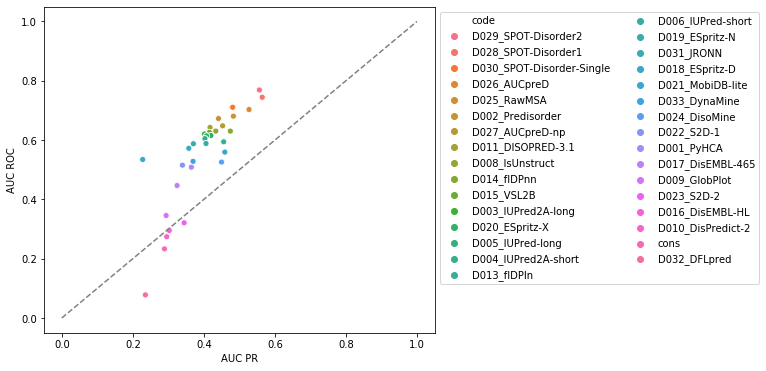

In [27]:
x = pd.DataFrame(filter_rescale(rocs + [rocs_base[0]], (0, 0.2)), columns=['code', 'AUC ROC']).set_index('code')
y = pd.DataFrame(filter_rescale(prcs + [prcs_base[0]], (0.8, 1)), columns=['code', 'AUC PR']).set_index('code')
data = pd.concat([x, y], axis=1).reset_index()

# m = list(zip(*zip(data['code'], cycle(['o', 'v', '^', '<', '>', '8', 's', 'p']))))[1]
fig, ax = plt.subplots(figsize=(7, 6))
data = data.sort_values(by='AUC ROC', ascending=False)

ax = sns.scatterplot(data=data.sort_values(by='AUC ROC', ascending=False), x='AUC PR', y='AUC ROC', hue='code', ax=ax)

ax.legend(bbox_to_anchor=(1, 1), ncol=2)
ax.plot((0, 1), (0, 1), linestyle='--', color='grey');

### Average overall ranking

Color are rescaled. Any pvalue above $0.05$ is **red** in the heatmap

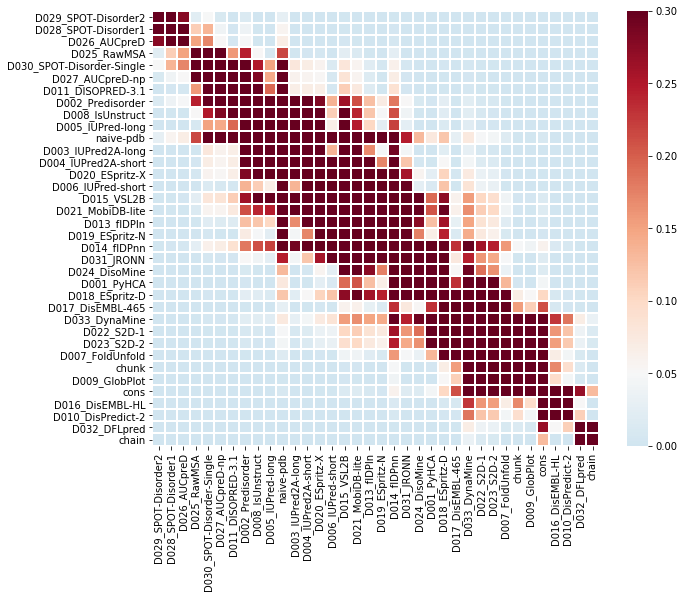

In [28]:
mm = scores[['BAc', 'MCC', 'Pre', 'Rec', 'F1s', 'F1s_n', 'Pre_n', 'Rec_n', 'AUC_ROC', 'AUC_PRC']].rank(axis=0, method='max', ascending=False, na_option='bottom')
mm = scores[['BAc', 'MCC', 'Pre', 'Rec', 'F1s', 'F1s_n', 'Pre_n', 'Rec_n', 'AUC_ROC', 'AUC_PRC']].rank(axis=0, method='max', ascending=False, na_option='bottom')
# mm = mm.drop('naif-gene3d')
indcol = mm.apply(np.mean, axis=1).sort_values()
dff = pd.DataFrame(index=indcol.index, columns=indcol.index, dtype=float)
del dff.index.name

for indx, rowx in sorted(mm.iterrows(), key=lambda r: r[1].mean(), reverse=True):
    for indy, rowy in sorted(mm.iterrows(), key=lambda r: r[1].mean(), reverse=True):
        dff.loc[indx][indy] = float(ttest_ind(rowx, rowy).pvalue)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(dff, cmap='RdBu_r', annot=False, linecolor='w', linewidth=1, xticklabels=True, 
            yticklabels=True, ax=ax, annot_kws={'size': 9}, fmt='.2f', cbar=True, center=0.05, vmin=0, vmax=0.3)

plt.yticks(rotation=0)
plt.xticks(rotation=90);

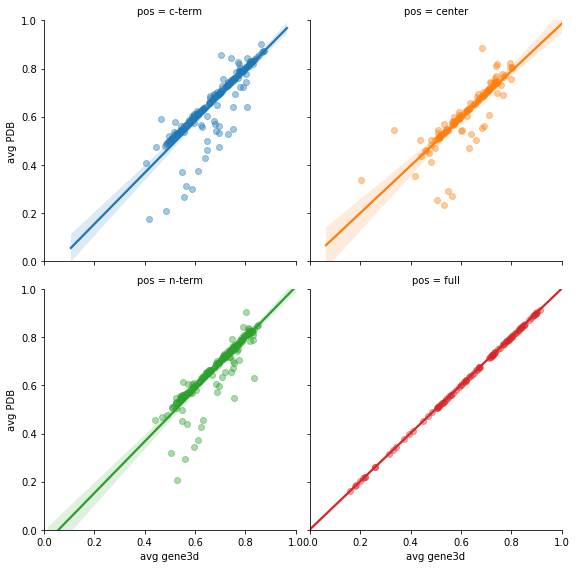

In [29]:
avg_acc = target_scores.xs('bal_acc', level=1)
t = pd.concat([avg_acc.mean(axis=0), avg_acc.std(axis=0)], axis=1, sort=False).rename(columns={0:'avg {}'.format(negatives), 1:'std {}'.format(negatives)})

negs2 = 'pdb'
target_scores2 = merge_targets_tables(reference, negs2, baseline_dir, results_dir)
avg_acc2 = target_scores2.xs('bal_acc', level=1)
t2 = pd.concat([avg_acc2.mean(axis=0), avg_acc2.std(axis=0)], axis=1, sort=False).rename(columns={0:'avg {}'.format(negs2.upper()), 1:'std {}'.format(negs2.upper())})

tt = pd.concat([t, t2], axis=1, sort=False)
tt['pos'] = pos

# fig, ax = plt.subplots(figsize=(8, 8))
# plt.errorbar(tt['average_{}'.format(negatives)], tt['average_pdb'], yerr=tt['std_{}'.format(negatives)] / 2, xerr=tt['std_pdb'] / 2, fmt='o', alpha=0.5);
g = sns.lmplot(data=tt, x='avg {}'.format(negatives), y='avg {}'.format(negs2.upper()), 
           hue='pos', col='pos', col_wrap=2, height=4, scatter_kws=dict(alpha=0.4))
g.set(ylim=(0, 1))
g.set(xlim=(0, 1));

## Consensus 

In [30]:
consensus = pd.read_csv(get_fname(reference, negatives, results_dir, 'consensusCM'), index_col=[0])
consensus_cm = consensus[consensus.columns] / consensus.iloc[1].sum().round(2) * 100
consensus_cm[['tn', 'fp']] *= -1

consensus['fpr'] = consensus['fp'] / (consensus['fp'] + consensus['tn'])
consensus['tpr'] = consensus['tp'] / (consensus['tp'] + consensus['fn'])
consensus['fnr'] = 1 - consensus['tpr']
consensus['tnr'] = 1 - consensus['fpr']

minfpr = consensus['fpr'][consensus['fpr'] < 0.05].sort_values().tail(1)
minfpr_idx, minfpr_value = minfpr.index.item(), minfpr.item()
minfnr = consensus['fnr'][consensus['fnr'] < 0.05].sort_values().tail(1)
minfnr_idx, minfnr_value = minfnr.index.item(), minfnr.item()

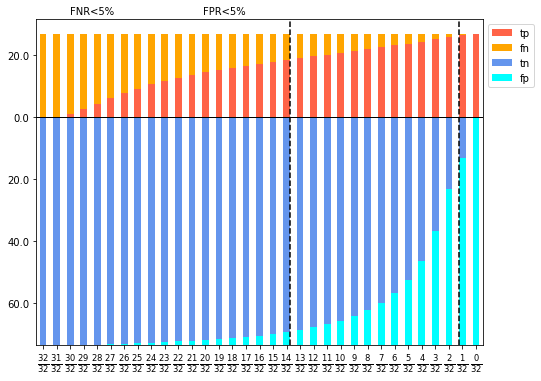

In [31]:
fig, ax = plt.subplots(figsize=(8, 6))

ax = consensus_cm[['tp', 'fn', 'tn', 'fp']].sort_index(ascending=False).plot.bar(stacked=True, ax=ax, color=['tomato', 'orange', 'cornflowerblue', 'cyan'])
# ax = (consensus_cm[['tn', 'fn']].sort_index(ascending=False) * -1).plot.bar(stacked=True, ax=ax, color=['red', 'green'])

ax.set_yticklabels(map(abs, ax.get_yticks()))
ax.set_xticklabels([r'$\frac{{{}}}{{{}}}$'.format(l.get_text(), len(consensus_cm) - 1) for l in ax.get_xticklabels()])
ax.tick_params(axis='x', which='both', rotation=0, labelsize=12)
ax.axhline(0, c='k', linewidth=1);

topplot = round(ax.get_ylim()[-1]) + 1
ax.axvline(len(consensus) - minfpr_idx + 0.25, linestyle='--', linewidth=1.5, c='k')
ax.axvline(len(consensus) - minfnr_idx - 0.25, linestyle='--', linewidth=1.5, c='k')
ax.text(minfpr_idx, topplot, 'FPR<5%', horizontalalignment='right')
ax.text(minfnr_idx, topplot, 'FNR<5%')
ax.legend(bbox_to_anchor=(1, 1));

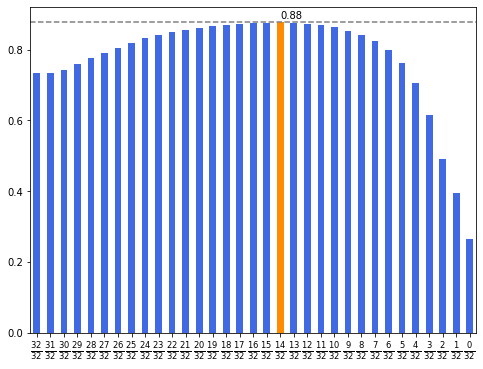

In [32]:
fig, ax = plt.subplots(figsize=(8, 6))

consensus_acc = abs(consensus_cm.sort_index(ascending=False)).apply(lambda s: (s['tp'] + s['tn']) / sum(s), axis=1).rename(columns={0:'Balanced Acc'})
colors = ["royalblue"] * len(consensus_acc)
colors[len(consensus_acc) - consensus_acc.sort_values(ascending=False).index[0] - 1] = "darkorange"
ax = consensus_acc.plot.bar(ax=ax, color=colors)
ax.set_xticklabels([r'$\frac{{{}}}{{{}}}$'.format(l.get_text(), len(consensus_cm) - 1) for l in ax.get_xticklabels()])
ax.tick_params(axis='x', which='both', rotation=0, labelsize=12)
maxacc = consensus_acc.max()
ax.axhline(maxacc, c='grey', linestyle='--')
ax.text(len(consensus_acc) - consensus_acc.sort_values(ascending=False).index[0] - 1, maxacc + 0.01, round(maxacc, 2));

In [33]:
nopdb = pd.read_csv(get_fname(reference, 'simple-nopdb', results_dir, 'scores'), index_col=[0])
pdb = pd.read_csv(get_fname(reference, 'pdb', results_dir, 'scores'), index_col=[0])

pos = ['TP', 'FN']
neg = ['TN', 'FP']
a = nopdb[pos].T.set_index(pd.MultiIndex.from_product([['DisProt'], pos])).T
b = pdb[neg].T.set_index(pd.MultiIndex.from_product([['PDB'], neg])).T
c = nopdb[neg].T.set_index(pd.MultiIndex.from_product([['Undefined'], neg])).T
# pd.concat([a, b, c], sort=False, axis=1).sum().groupby(level=0).apply(lambda g: g.apply(lambda x: x / g.sum())).to_frame().rename(columns={0:'%'})
pd.concat([a, b, c], sort=False, axis=1).T.groupby(level=0).apply(lambda g: g.apply(lambda s: s.apply(lambda x: x / s.sum()))).round(3) * 100

D006_IUPred-short  D021_MobiDB-lite  D022_S2D-1  D025_RawMSA  \
DisProt   TP               56.2              41.1        86.7         68.2   
          FN               43.8              58.9        13.3         31.8   
PDB       TN               94.7              98.6        47.3         93.1   
          FP                5.3               1.4        52.7          6.9   
Undefined TN               66.2              77.2        22.3         60.6   
          FP               33.8              22.8        77.7         39.4   

              D005_IUPred-long  D007_FoldUnfold  D004_IUPred2A-short  \
DisProt   TP              64.5             66.6                 56.3   
          FN              35.5             33.4                 43.7   
PDB       TN              92.5             82.5                 94.9   
          FP               7.5             17.5                  5.1   
Undefined TN              58.9             48.8                 66.3   
          FP              41.1             51.2                 33.7   

              D033_DynaMine  D001_PyHCA  D009_GlobPlot  ...  D013_fIDPln  \
DisProt   TP            1.7        65.8           38.3  ...         50.5   
          FN           98.3        34.2           61.7  ...         49.5   
PDB       TN          100.0        84.8           90.0  ...         94.6   
          FP            0.0        15.2           10.0  ...          5.4   
Undefined TN           97.9        53.7           70.0  ...         79.3   
          FP            2.1        46.3           30.0  ...         20.7   

              D011_DISOPRED-3.1  D019_ESpritz-N  D016_DisEMBL-HL  \
DisProt   TP               64.5            68.7             53.0   
          FN               35.5            31.3             47.0   
PDB       TN               93.9            86.6             74.4   
          FP                6.1            13.4             25.6   
Undefined TN               49.9            51.6             63.8   
          FP               50.1            48.4             36.2   

              D027_AUCpreD-np  D008_IsUnstruct  D018_ESpritz-D  D031_JRONN  \
DisProt   TP             57.3             74.8            35.2        74.1   
          FN             42.7             25.2            64.8        25.9   
PDB       TN             96.5             86.0            95.6        81.7   
          FP              3.5             14.0             4.4        18.3   
Undefined TN             65.1             49.3            88.4        47.3   
          FP             34.9             50.7            11.6        52.7   

              D015_VSL2B  D010_DisPredict-2  
DisProt   TP        81.5               41.6  
          FN        18.5               58.4  
PDB       TN        77.2               81.6  
          FP        22.8               18.4  
Undefined TN        40.0               72.5  
          FP        60.0               27.5  

[6 rows x 32 columns]

In [34]:
tgt, preds = load_predstack(get_fname(reference, negatives, results_dir, 'predstack'))

In [35]:
pred_corr = pd.DataFrame(index=preds.keys(), columns=preds.keys())
pred_corr_pvals = pd.DataFrame(index=preds.keys(), columns=preds.keys())


for pi in preds:
    if '/' not in pi or pi.split('/')[0] in (str(minfpr_idx - 1), str(minfnr_idx - 1)):
        for pj in preds:
            if '/' not in pj or pj.split('/')[0] in (str(minfpr_idx), str(minfnr_idx)):
                r, p = pearsonr(preds[pi], preds[pj])
                pred_corr.loc[pi][pj] = r
                pred_corr_pvals.loc[pi][pj] = p

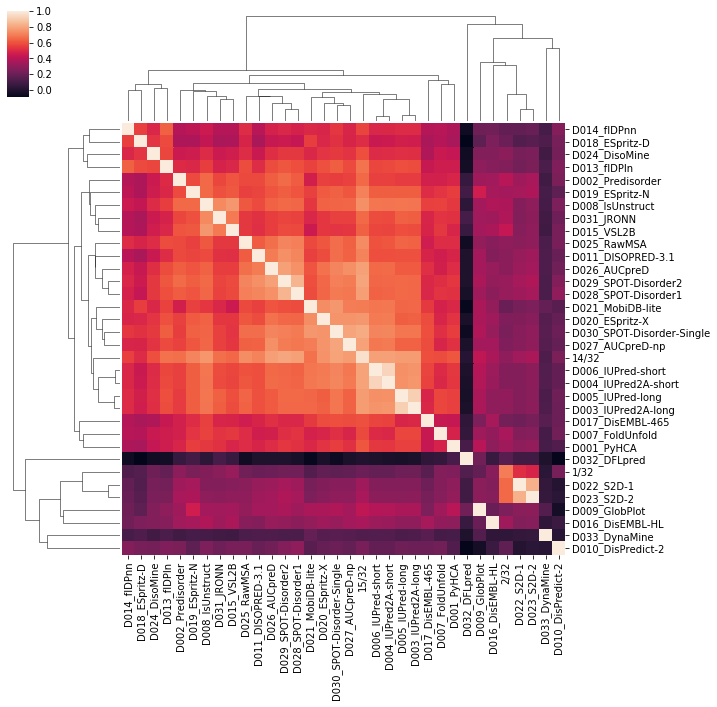

In [36]:
sns.clustermap(pred_corr.dropna(0, how='all').dropna(1, how='all').astype(float));